Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


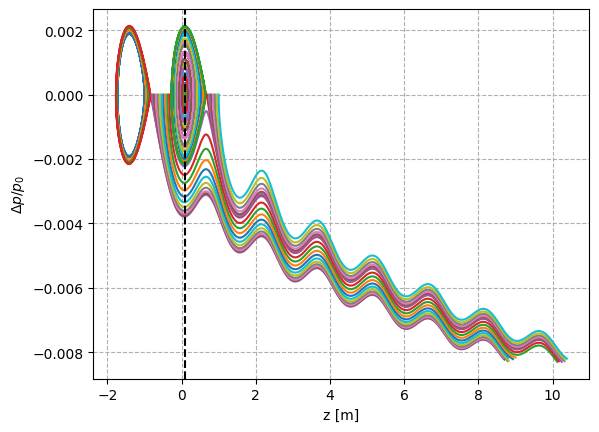

In [2]:
import json
import numpy as np

import xobjects as xo
import xpart as xp
import xtrack as xt

T_rev = 23e-6 # 23 us
Delta_p0c = 450e9 / 10 * T_rev

fname_line = ('line_no_spacecharge_and_particle.json')

with open(fname_line, 'r') as fid:
     input_data = json.load(fid)
line = xt.Line.from_dict(input_data['line'])

energy_increase = xt.ReferenceEnergyIncrease(Delta_p0c=Delta_p0c)
line.append_element(energy_increase, 'energy_increase')

line.build_tracker()

particles = xp.Particles(p0c=26e9, zeta=np.linspace(-1, 1, 40))

line.track(particles, num_turns=500, turn_by_turn_monitor=True)

#!end-doc-part

rec = line.record_last_track
import matplotlib.pyplot as plt
plt.close('all')
plt.figure(1)
for ii in range(rec.x.shape[0]):
    mask = rec.state[ii, :]>0
    plt.plot(rec.zeta[ii, mask], rec.delta[ii, mask])

plt.grid(linestyle='--')
plt.xlabel('z [m]')
plt.ylabel(r'$\Delta p / p_0$')

## Quick check for stable phase

from scipy.constants import c as clight

# Assume only first cavity is active
frequency = line.get_elements_of_type(xt.Cavity)[0][0].frequency
voltage = line.get_elements_of_type(xt.Cavity)[0][0].voltage
#Assuming proton and beta=1
stable_z = np.arcsin(Delta_p0c/voltage)/frequency/2/np.pi*clight

p_co = line.find_closed_orbit(particle_ref=xp.Particles.from_dict(
                          input_data['particle']))

assert np.isclose(p_co.zeta, stable_z, atol=0, rtol=1e-2)

plt.axvline(x=stable_z, color='black', linestyle='--')

plt.show()